import packages

In [89]:
import torch
import torchvision
import torchvision.transforms as transforms
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from torch import Tensor, einsum
from torch import nn
from torch.nn import functional as F
from scipy.ndimage import distance_transform_edt as distance
from scipy.spatial.distance import directed_hausdorff
 

In [90]:
!pip install segmentation-models-pytorch==0.1.0
!pip install keras-unet

 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [91]:
import segmentation_models_pytorch as smp
from keras_unet.utils import plot_imgs


In [92]:
size = 128
bs = 16 #batchsize
classes = [ 1, 2, 4,  5,  6,  7,  8,  9, 10, 15]
num_class= len(classes)
EPOCH= 200

Used to crop the imput images

In [93]:
def slice (arr, size, inputsize,stride):
    result = []
    if stride is None:
        stride = size
    for i in range(0, (inputsize-size)+1, stride):
        for j in range(0, (inputsize-size)+1, stride):
        
            if arr.ndim == 3:
                s = arr[:,i:(i+size),j:(j+size), ]
            else:
                s = arr[i:(i+size),j:(j+size), ]
            result.append(s)
 
 
    result = np.array(result)
    return result

def batchslice (arr, size, inputsize, stride, num_img):
    result = []
    for i in range(0, num_img):
        s= slice(arr[i,], size, inputsize, stride )
        result.append(s )
    result = np.array(result)
    result = result.reshape(result.shape[0]*result.shape[1], result.shape[2], result.shape[3], -1)
    return result


load the different tiles into 1 variable

In [94]:
reduce = 8
#stack all files into 1 variable
def load_raster(path,data,tile1,tile2):
   tiles_in=[tile1,tile2]
   files = []
   for tile in tiles_in:
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
   stacked = np.array(files)
   return stacked

def load_data(path,data1,data2,tile1,tile2):
   part1 = load_raster(path,data1,tile1,tile2)
   part2 = load_raster(path,data2,tile1,tile2)
   print(part1.shape,part2.shape)
   if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
   elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
   print(part1.shape,part2.shape)
   total = np.concatenate((part1,part2),axis=1)
   return total



Slice input data into smaller size images

In [95]:
training= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8")
validation = load_data("../input/guided-research/Validation/","DEM","Wadden","12_8","14_7")
y_train= load_raster("../input/guided-research/Training/","class","12_7","13_8")
y_val=load_raster("../input/guided-research/Validation/","class","12_8","14_7")

(2, 2000, 2000) (2, 3, 2000, 2000)
(2, 1, 2000, 2000) (2, 3, 2000, 2000)
(2, 2000, 2000) (2, 3, 2000, 2000)
(2, 1, 2000, 2000) (2, 3, 2000, 2000)


In [96]:
from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union


In [97]:
def uniq(a: Tensor) -> Set:
    return set(torch.unique(a.cpu()).numpy())


def sset(a: Tensor, sub: Iterable) -> bool:
    return uniq(a).issubset(sub)

def simplex(t: Tensor, axis=1) -> bool:
    _sum = t.sum(axis).type(torch.float32)
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)


def one_hot(t: Tensor, axis=1) -> bool:
    return simplex(t, axis) and sset(t, [0, 1])

def one_hot2dist(seg: np.ndarray) -> np.ndarray:
    assert one_hot(torch.Tensor(seg), axis=0)
    C: int = len(seg)

    res = np.zeros_like(seg)
    for c in range(C):
        posmask = seg[c].astype(np.bool)

        if posmask.any():
            negmask = ~posmask
            res[c] = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    return res

In [98]:

    

''' 
class GeneralizedDice():
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc: List[int] = kwargs["idc"]
        print(f"Initialized {self.__class__.__name__} with {kwargs}")

    def __call__(self, probs: Tensor, target: Tensor, _: Tensor) -> Tensor:
        assert simplex(probs) and simplex(target)

        pc = probs[:, self.idc, ...].type(torch.float32)
        tc = target[:, self.idc, ...].type(torch.float32)

        w: Tensor = 1 / ((einsum("bcwh->bc", tc).type(torch.float32) + 1e-10) ** 2)
        intersection: Tensor = w * einsum("bcwh,bcwh->bc", pc, tc)
        union: Tensor = w * (einsum("bcwh->bc", pc) + einsum("bcwh->bc", tc))

        divided: Tensor = 1 - 2 * (einsum("bc->b", intersection) + 1e-10) / (einsum("bc->b", union) + 1e-10)

        loss = divided.mean()

        return loss

class DiceLoss():
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc: List[int] = kwargs["idc"]
        print(f"Initialized {self.__class__.__name__} with {kwargs}")

    def __call__(self, probs: Tensor, target: Tensor, _: Tensor) -> Tensor:
        assert simplex(probs) and simplex(target)

        pc = probs[:, self.idc, ...].type(torch.float32)
        tc = target[:, self.idc, ...].type(torch.float32)

        intersection: Tensor = einsum("bcwh,bcwh->bc", pc, tc)
        union: Tensor = (einsum("bcwh->bc", pc) + einsum("bcwh->bc", tc))

        divided: Tensor = 1 - (2 * intersection + 1e-10) / (union + 1e-10)

        loss = divided.mean()

        return loss


class SurfaceLoss():
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc: List[int] = kwargs["idc"]
        print(f"Initialized {self.__class__.__name__} with {kwargs}")

    def __call__(self, probs: Tensor, dist_maps: Tensor, _: Tensor) -> Tensor:
        assert simplex(probs)
        assert not one_hot(dist_maps)

        pc = probs[:, self.idc, ...].type(torch.float32)
        dc = dist_maps[:, self.idc, ...].type(torch.float32)

        multipled = einsum("bcwh,bcwh->bcwh", pc, dc)

        loss = multipled.mean()

        return loss

'''     

' \nclass GeneralizedDice():\n    def __init__(self, **kwargs):\n        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing\n        self.idc: List[int] = kwargs["idc"]\n        print(f"Initialized {self.__class__.__name__} with {kwargs}")\n\n    def __call__(self, probs: Tensor, target: Tensor, _: Tensor) -> Tensor:\n        assert simplex(probs) and simplex(target)\n\n        pc = probs[:, self.idc, ...].type(torch.float32)\n        tc = target[:, self.idc, ...].type(torch.float32)\n\n        w: Tensor = 1 / ((einsum("bcwh->bc", tc).type(torch.float32) + 1e-10) ** 2)\n        intersection: Tensor = w * einsum("bcwh,bcwh->bc", pc, tc)\n        union: Tensor = w * (einsum("bcwh->bc", pc) + einsum("bcwh->bc", tc))\n\n        divided: Tensor = 1 - 2 * (einsum("bc->b", intersection) + 1e-10) / (einsum("bc->b", union) + 1e-10)\n\n        loss = divided.mean()\n\n        return loss\n\nclass DiceLoss():\n    def __init__(self, **kwargs):\n        # Self.idc

In [99]:
print(training.shape, validation.shape,y_train.shape, y_val.shape)

(2, 4, 2000, 2000) (2, 4, 2000, 2000) (2, 2000, 2000) (2, 2000, 2000)


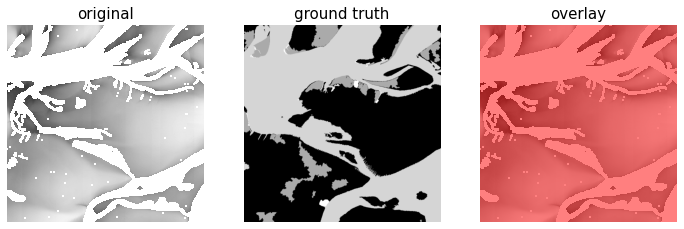

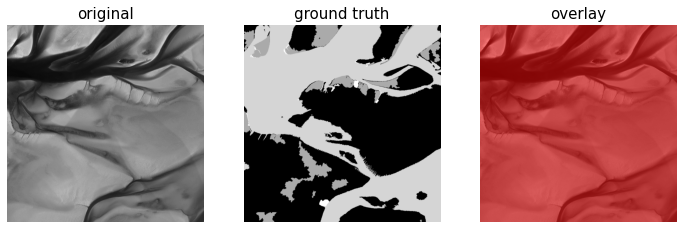

In [100]:

plot_imgs(
    org_imgs=training[1:2,0,:,:], # required - original images
    mask_imgs=y_train[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot

plot_imgs(
    org_imgs=training[1:2,2,:,:], # required - original images
    mask_imgs=y_train[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot

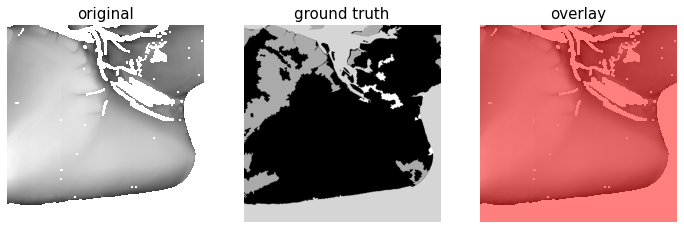

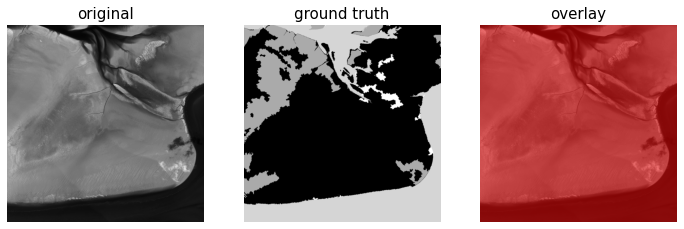

In [101]:
#np.moveaxis(validation[0:2,[1,2,3], :,:], 1 , -1)
plot_imgs(
    org_imgs=validation[1:2,0, :,:], # required - original images
    mask_imgs=y_val[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot
plot_imgs(
    org_imgs=validation[1:2,1, :,:], # required - original images
    mask_imgs=y_val[1:2,:,:], # required - ground truth masks
    
    nm_img_to_plot=3) # optional - number of images to plot

In [102]:
#a= np.moveaxis(validation[1:2 ,1:4,:,:], 1, -1)
 

In [103]:
training.shape

(2, 4, 2000, 2000)

In [104]:
training  = batchslice(training,size,training[0].shape[1],size,training.shape[0])
validation=batchslice(validation,size,validation[0].shape[1],size,validation.shape[0])

y_train = batchslice(y_train,size,y_train[0].shape[1],size,y_train.shape[0]).squeeze()
y_val = batchslice(y_val,size,y_val[0].shape[1],size,y_val.shape[0]).squeeze()
  

print(training.shape,validation.shape,y_train.shape, y_val.shape)


(450, 4, 128, 128) (450, 4, 128, 128) (450, 128, 128) (450, 128, 128)


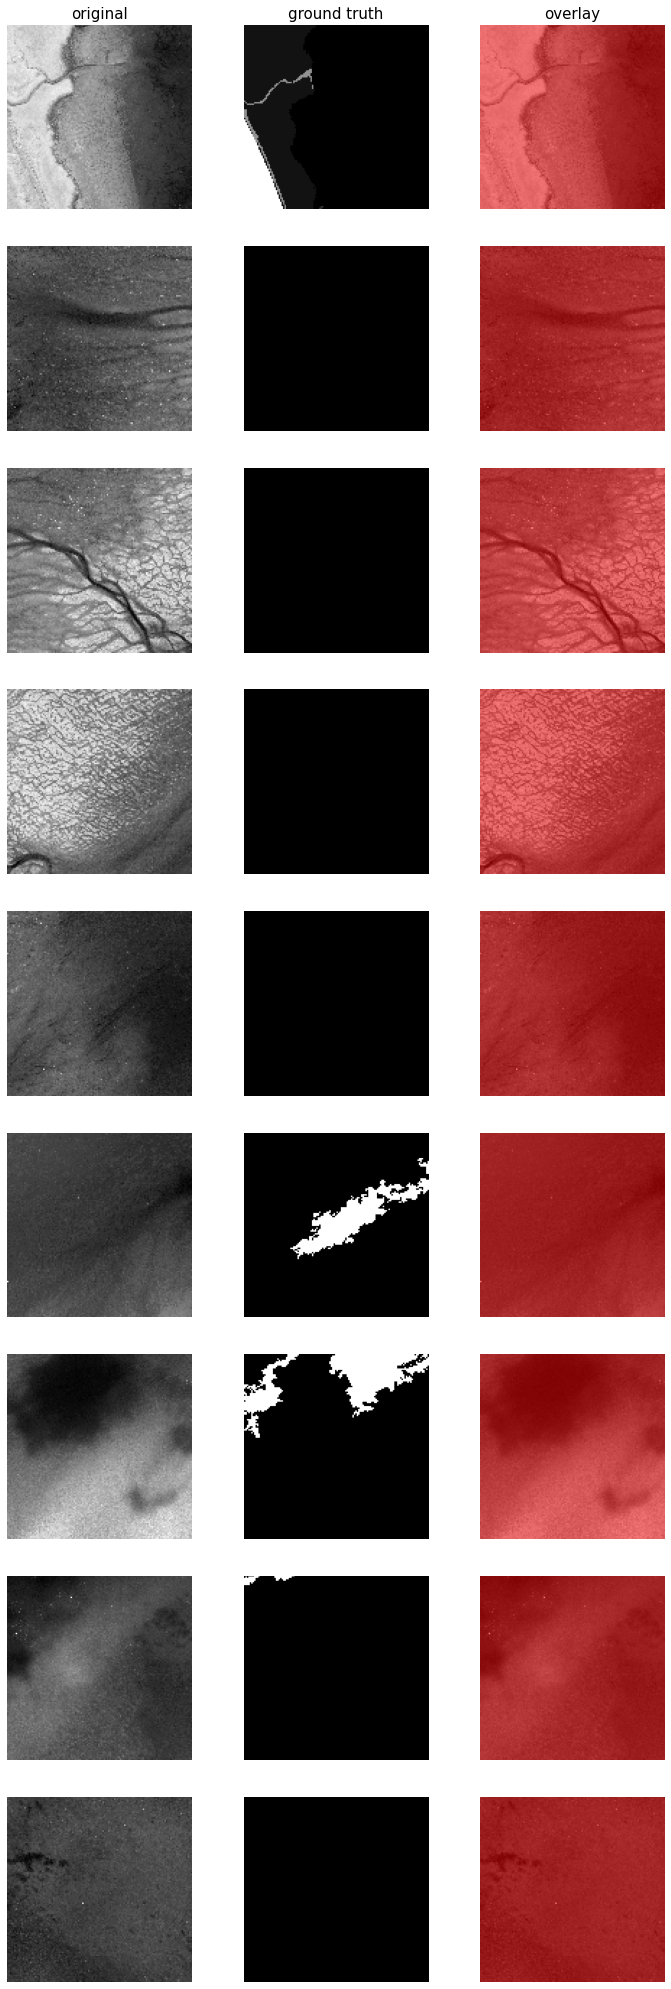

In [105]:
#plt.itraining= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8")mshow(validation[1,0,:,:])
#plt.show() 
plot_imgs(
    org_imgs=validation[0:9,1, :,:], # required - original images
    mask_imgs=y_val[0:9,:,:], # required - ground truth masks
    
    nm_img_to_plot=10) # optional - number of images to plot

In [106]:
#for wh in range(10,20):
#    plt.imshow(validation[wh,0,:,:])
#    plt.show() 
#    plt.imshow(validation[wh,2,:,:])
#    plt.show() 
#    plt.imshow(y_val[wh,:,:])
#    plt.show()  

In [107]:
def class2dim (mask, CLASSES):
    
        masks = [(mask == v) for v in CLASSES ]
        mask = np.stack(masks, axis=-1).astype('float')    
        return mask



      

In [108]:
new_mask = class2dim(y_train, classes)
new_mas_val = class2dim(y_val, classes)

In [109]:
#check
#whichone = 5
#print(np.amax(y_train[whichone,] ),np.amin(y_train[whichone,] ))
#plt.imshow(y_train[whichone,] )
#plt.show() 
#for n in range(num_class): 
#    plt.imshow(new_mask[whichone,:,:,n])     
#    plt.show() 


Code used to see slicing result

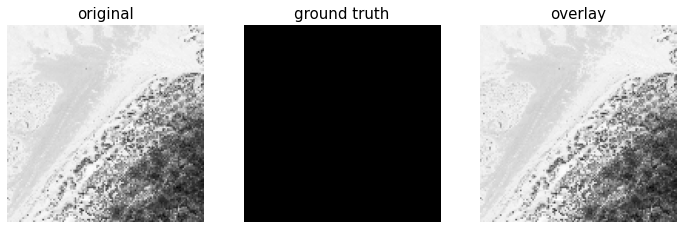

/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning:


<string>:6: UserWarning:


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning:




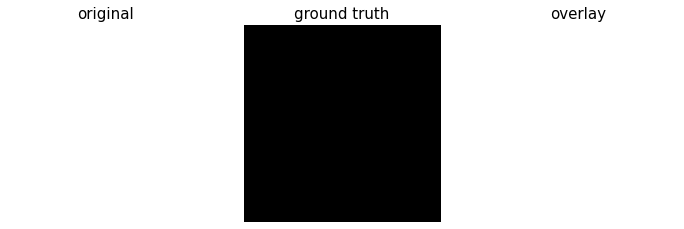

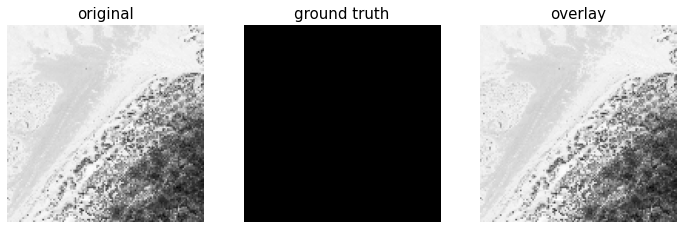

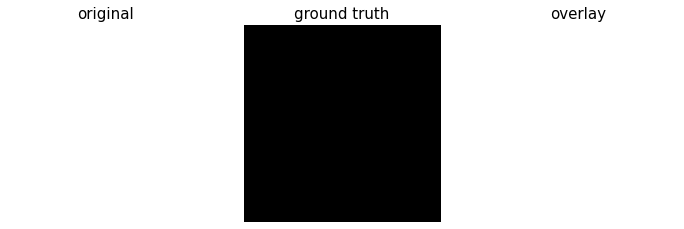

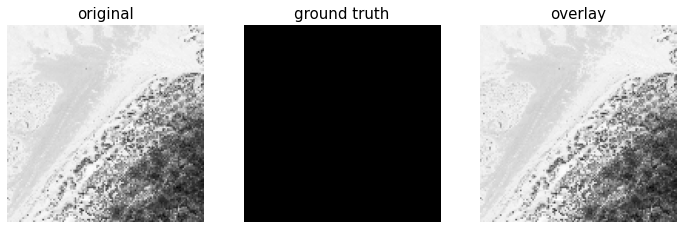

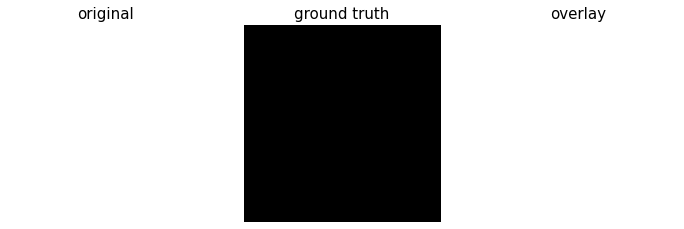

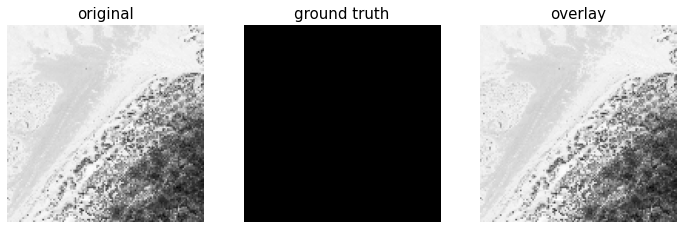

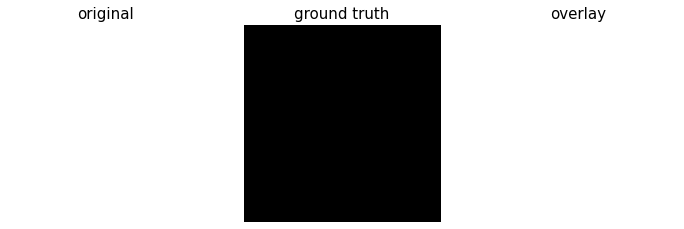

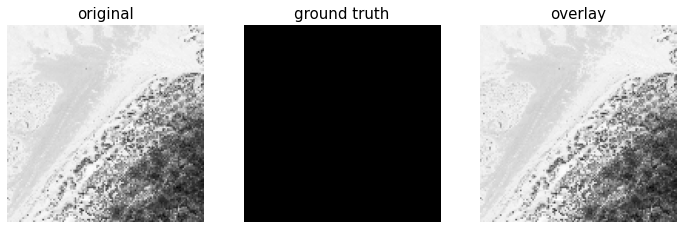

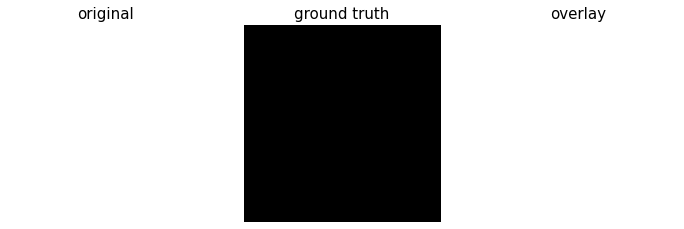

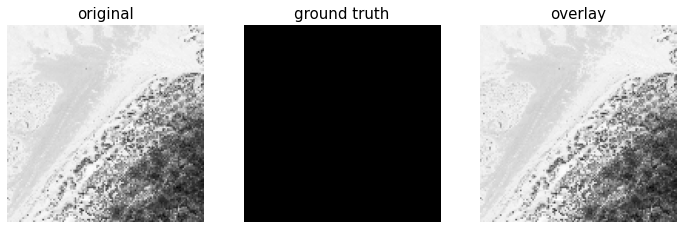

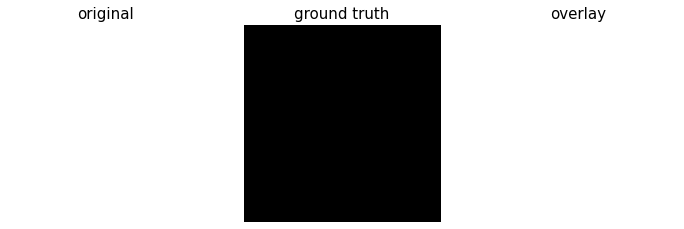

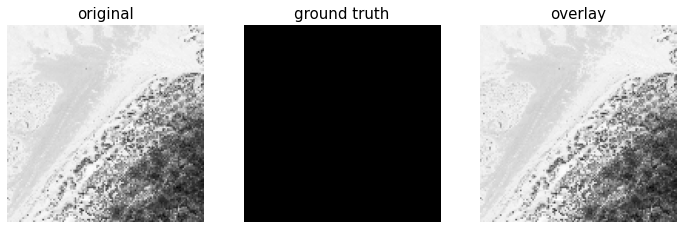

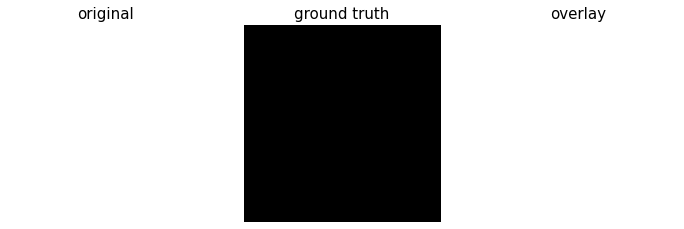

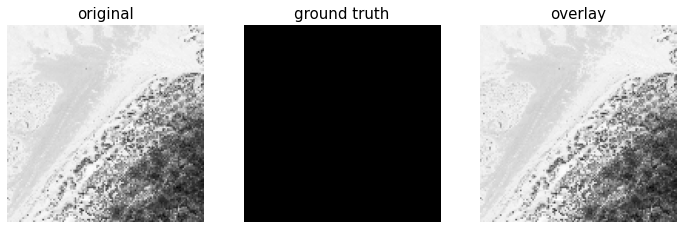

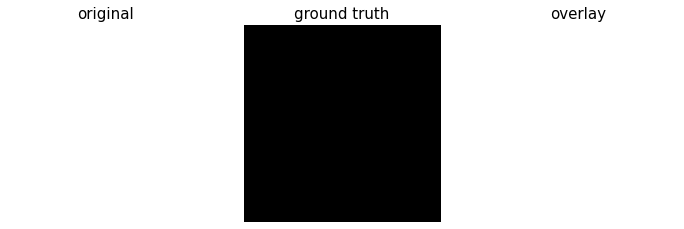

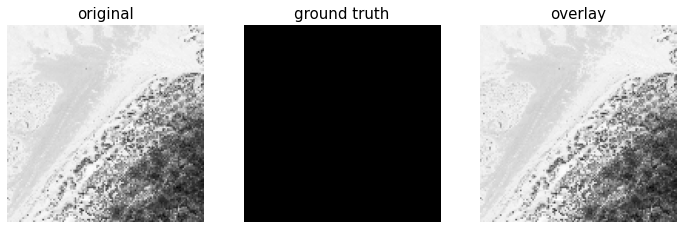

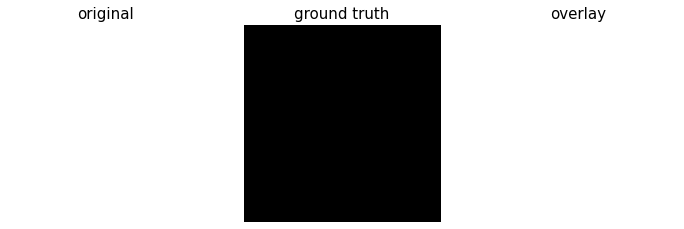

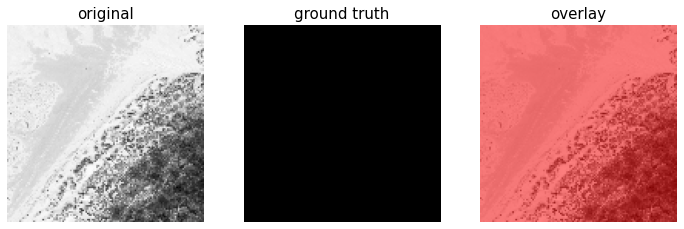

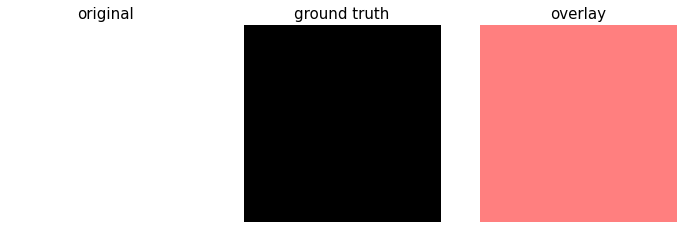

In [110]:
for i in range(len(classes)):
    plot_imgs(
    org_imgs=training[50:51, 2, :,: ],
    mask_imgs=new_mask[50:51,:,:,i], # required - original images 

    nm_img_to_plot=10) # optional - number of images to plot

    plot_imgs(
    org_imgs=training[50:51, 0, :,: ],
    mask_imgs=new_mask[50:51,:,:,i], # required - original images 

    nm_img_to_plot=10) # optional - number of images to plot

 


In [111]:
new_mask =  np.moveaxis(new_mask, -1, 1)
new_mas_val = np.moveaxis(new_mas_val, -1, 1)

In [112]:
new_mask.shape

(450, 10, 128, 128)

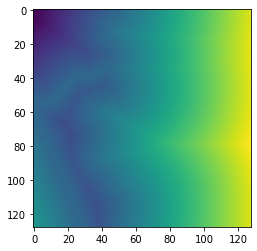

In [113]:
plt.imshow(new_mas_val[0,1,])
a = one_hot2dist(new_mas_val[0,])
plt.imshow(a[1,])

In [114]:
training[training> 1e308] = 0 
#np.nan
validation[validation> 1e308] =0 
new_mask[new_mask >1e308] = 0
new_mas_val[new_mas_val> 1e308] = 0

training = list(zip(training[:,1,:,:], y_train))
validation = list(zip(validation[:,1,:,:], y_val))m
 

In [115]:
#np.save("../wadden1", zip(training, new_mask, validation, new_mas_val))

Get torch loader, got the error in catalyst with "collection dont have attribute size", use original array as demonstrated in catalyst

In [116]:
#net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')
#print(net)

In [117]:
#CLASSES = [format(x, '2d') for x in  classes]
 
#model = smp.Unet(classes=len(CLASSES), in_channels=3,activation="sigmoid")
#newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
#print(model)


In [118]:
#model = net
 

In [119]:
#comparison = training == validation
#equal_arrays = comparison.all()
#print(equal_arrays)
#inputs, masks = next(iter(loaders['valid']))
 

Pre-trained Unet segmentation model

In [120]:
from catalyst.dl import utils
import collections
from catalyst.data import Augmentor
import torchvision.transforms as transforms

open_fn = lambda x: {"features": x[0], "targets": x[1]}
data_transform = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 1.)),
  #  Augmentor(
  #      dict_key="features",
  #      augment_fn=transforms.Normalize(
  #          (0.5, ),
  #          (0.5, ))),
    Augmentor(
        dict_key="targets",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 1.) )
])
#.unsqueeze_(0)


train_loader = utils.get_loader(
    list(zip(training.astype(np.float32), new_mask.astype(np.float32))), 
    open_fn=open_fn,  
    batch_size=bs, 
    dict_transform=data_transform, 
    num_workers=4, 
    shuffle=True)

valid_loader = utils.get_loader(
    list(zip(validation.astype(np.float32), new_mas_val.astype(np.float32))), 
    open_fn=open_fn,  
    batch_size=bs, 
    dict_transform=data_transform, 
    num_workers=4, 
    shuffle=False)

 
from catalyst.dl import utils
 
loaders = collections.OrderedDict()


loaders["train"] = train_loader
loaders["valid"] =valid_loader

In [121]:
for i, inputs in enumerate (loaders['train']): 
         
         print (inputs['features'].shape)

torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([2, 4, 128, 128])


%load_ext tensorboard
%tensorboard --logdir {logdir}

In [122]:
GAMMA = 2
ALPHA = 0.8 # emphasize FP
BETA = 0.2 # more emphasize on FN

In [123]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


     
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, **kwargs):
        super(IoULoss, self).__init__(**kwargs)

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
 

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

class myLoss(torch.nn.Module):

    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight

    def forward(self, input, target):
      epsilon = 10 ** -44
      input = input.sigmoid().clamp(epsilon, 1 - epsilon)

      my_bce_loss = -1 * (self.pos_weight * target * torch.log(input)
                          + (1 - target) * torch.log(1 - input))
      add_loss = (target - 0.5) ** 2 * 4
      mean_loss = (my_bce_loss * add_loss).mean()
      return mean_loss
    
 

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss
    

In [124]:
from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback
# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}


callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

 

In [125]:
#from catalyst.contrib.models.cv import Unet,ResnetUnet
#from catalyst.contrib.nn import DiceLoss, IoULoss, NLLLoss

from catalyst.dl import SupervisedRunner

# experiment setup
num_epochs =EPOCH
logdir = "segmentation_notebook"

# model, criterion, optimizer
#model =  torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=num_class)
#model =Unet(num_classes=num_class, in_channels=4, num_channels=64, num_blocks=4)# catalyst Unet
#model = ResnetUnet(num_classes=num_class) # can only take 3 channels 
model = smp.Unet(classes=num_class, in_channels=4, activation = None)
 
criterion = FocalTverskyLoss()
#"sigmoid" nn.BCELoss()
#smp.utils.losses.DiceLoss()
#WithLogits 
#myLoss()
#nn.BCEWithLogitsLoss() # this and myLoss() can run but gradient does not descent. 
# nn.CrossEntropyLoss()  # the type should be Long
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)



# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    #callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True,
    main_metric='iou',
    callbacks=[ 
        IouCallback(),
    ],
    load_best_on_end=True,
)
 

1/200 * Epoch (train):   0% 0/29 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



1/200 * Epoch (train): 100% 29/29 [00:02<00:00, 10.85it/s, iou=0.103, loss=0.749]
1/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.34it/s, iou=0.182, loss=0.602]
[2020-10-21 21:41:11,449] 
1/200 * Epoch 1 (_base): lr=0.0002 | momentum=0.9000
1/200 * Epoch 1 (train): iou=0.1169 | loss=0.7228
1/200 * Epoch 1 (valid): iou=0.1270 | loss=0.7022
2/200 * Epoch (train): 100% 29/29 [00:02<00:00, 10.66it/s, iou=0.154, loss=0.648]
2/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 15.67it/s, iou=0.243, loss=0.498]
[2020-10-21 21:41:19,716] 
2/200 * Epoch 2 (_base): lr=0.0002 | momentum=0.9000
2/200 * Epoch 2 (train): iou=0.1545 | loss=0.6492
2/200 * Epoch 2 (valid): iou=0.1668 | loss=0.6244
3/200 * Epoch (train): 100% 29/29 [00:03<00:00,  9.61it/s, iou=0.155, loss=0.638]
3/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.00it/s, iou=0.258, loss=0.470]
[2020-10-21 21:41:25,603] 
3/200 * Epoch 3 (_base): lr=0.0002 | momentum=0.9000
3/200 * Epoch 3 (train): iou=0.1897 | loss=0.5838
3/200 * Epoch 3 (v

24/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.39it/s, iou=0.941, loss=0.001]
[2020-10-21 21:43:35,908] 
24/200 * Epoch 24 (_base): lr=0.0002 | momentum=0.9000
24/200 * Epoch 24 (train): iou=0.6000 | loss=0.0583
24/200 * Epoch 24 (valid): iou=0.6588 | loss=0.0561
25/200 * Epoch (train): 100% 29/29 [00:02<00:00, 10.65it/s, iou=0.188, loss=0.451]
25/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.52it/s, iou=0.925, loss=0.002]
[2020-10-21 21:43:41,512] 
25/200 * Epoch 25 (_base): lr=0.0002 | momentum=0.9000
25/200 * Epoch 25 (train): iou=0.6356 | loss=0.0442
25/200 * Epoch 25 (valid): iou=0.6357 | loss=0.0653
26/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.32it/s, iou=0.339, loss=0.233]
26/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.67it/s, iou=0.488, loss=0.109]
[2020-10-21 21:43:48,151] 
26/200 * Epoch 26 (_base): lr=0.0002 | momentum=0.9000
26/200 * Epoch 26 (train): iou=0.5925 | loss=0.0587
26/200 * Epoch 26 (valid): iou=0.4255 | loss=0.1941
27/200 * Epoch (train): 100

47/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 19.91it/s, iou=0.982, loss=8.197e-05]
[2020-10-21 21:45:55,941] 
47/200 * Epoch 47 (_base): lr=0.0002 | momentum=0.9000
47/200 * Epoch 47 (train): iou=0.6756 | loss=0.0275
47/200 * Epoch 47 (valid): iou=0.5235 | loss=0.1000
48/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.48it/s, iou=0.447, loss=0.121]
48/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.70it/s, iou=0.969, loss=2.378e-04]
[2020-10-21 21:46:03,380] 
48/200 * Epoch 48 (_base): lr=0.0002 | momentum=0.9000
48/200 * Epoch 48 (train): iou=0.6317 | loss=0.0346
48/200 * Epoch 48 (valid): iou=0.6629 | loss=0.0400
49/200 * Epoch (train): 100% 29/29 [00:02<00:00, 10.79it/s, iou=0.184, loss=0.453]
49/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.88it/s, iou=0.665, loss=0.040]
[2020-10-21 21:46:10,235] 
49/200 * Epoch 49 (_base): lr=0.0002 | momentum=0.9000
49/200 * Epoch 49 (train): iou=0.6446 | loss=0.0319
49/200 * Epoch 49 (valid): iou=0.6390 | loss=0.0436
50/200 * Epoch (tra

70/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 18.79it/s, iou=0.992, loss=1.783e-05]
[2020-10-21 21:48:24,585] 
70/200 * Epoch 70 (_base): lr=0.0002 | momentum=0.9000
70/200 * Epoch 70 (train): iou=0.6938 | loss=0.0216
70/200 * Epoch 70 (valid): iou=0.6038 | loss=0.0696
71/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.18it/s, iou=0.327, loss=0.236]
71/200 * Epoch (valid): 100% 29/29 [00:02<00:00, 13.73it/s, iou=0.981, loss=5.712e-05]
[2020-10-21 21:48:30,842] 
71/200 * Epoch 71 (_base): lr=0.0002 | momentum=0.9000
71/200 * Epoch 71 (train): iou=0.6668 | loss=0.0240
71/200 * Epoch 71 (valid): iou=0.6956 | loss=0.0280
72/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.36it/s, iou=0.109, loss=0.621]
72/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.44it/s, iou=0.997, loss=3.203e-06]
[2020-10-21 21:48:36,231] 
72/200 * Epoch 72 (_base): lr=0.0002 | momentum=0.9000
72/200 * Epoch 72 (train): iou=0.6741 | loss=0.0272
72/200 * Epoch 72 (valid): iou=0.3561 | loss=0.2643
73/200 * Epoch 

93/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.86it/s, iou=0.915, loss=4.206e-04]
[2020-10-21 21:50:44,732] 
93/200 * Epoch 93 (_base): lr=0.0002 | momentum=0.9000
93/200 * Epoch 93 (train): iou=0.6760 | loss=0.0224
93/200 * Epoch 93 (valid): iou=0.6638 | loss=0.0323
94/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.11it/s, iou=0.442, loss=0.122]
94/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.76it/s, iou=0.813, loss=0.002]
[2020-10-21 21:50:50,123] 
94/200 * Epoch 94 (_base): lr=0.0002 | momentum=0.9000
94/200 * Epoch 94 (train): iou=0.6300 | loss=0.0289
94/200 * Epoch 94 (valid): iou=0.4710 | loss=0.1383
95/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.06it/s, iou=0.276, loss=0.275]
95/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.28it/s, iou=0.988, loss=2.995e-05]
[2020-10-21 21:50:56,975] 
95/200 * Epoch 95 (_base): lr=0.0002 | momentum=0.9000
95/200 * Epoch 95 (train): iou=0.6081 | loss=0.0420
95/200 * Epoch 95 (valid): iou=0.6724 | loss=0.0414
96/200 * Epoch (tra

116/200 * Epoch (train): 100% 29/29 [00:02<00:00, 10.12it/s, iou=0.113, loss=0.612]
116/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.67it/s, iou=0.991, loss=1.241e-05]
[2020-10-21 21:53:08,391] 
116/200 * Epoch 116 (_base): lr=0.0002 | momentum=0.9000
116/200 * Epoch 116 (train): iou=0.7209 | loss=0.0156
116/200 * Epoch 116 (valid): iou=0.6581 | loss=0.0427
117/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.25it/s, iou=0.226, loss=0.359]
117/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.35it/s, iou=0.994, loss=7.432e-06]
[2020-10-21 21:53:15,759] 
117/200 * Epoch 117 (_base): lr=0.0002 | momentum=0.9000
117/200 * Epoch 117 (train): iou=0.6996 | loss=0.0181
117/200 * Epoch 117 (valid): iou=0.2840 | loss=0.3600
118/200 * Epoch (train): 100% 29/29 [00:03<00:00,  8.77it/s, iou=0.207, loss=0.411]
118/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 18.20it/s, iou=0.995, loss=2.706e-06]
[2020-10-21 21:53:22,257] 
118/200 * Epoch 118 (_base): lr=0.0002 | momentum=0.9000
118/200 * Epoch 

139/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.28it/s, iou=0.299, loss=0.238]
139/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.31it/s, iou=0.996, loss=2.343e-06]
[2020-10-21 21:55:33,767] 
139/200 * Epoch 139 (_base): lr=0.0002 | momentum=0.9000
139/200 * Epoch 139 (train): iou=0.7239 | loss=0.0147
139/200 * Epoch 139 (valid): iou=0.7347 | loss=0.0236
140/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.35it/s, iou=0.483, loss=0.084]
140/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 17.08it/s, iou=0.994, loss=5.397e-06]
[2020-10-21 21:55:39,815] 
140/200 * Epoch 140 (_base): lr=0.0002 | momentum=0.9000
140/200 * Epoch 140 (train): iou=0.6970 | loss=0.0208
140/200 * Epoch 140 (valid): iou=0.6086 | loss=0.0406
141/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.43it/s, iou=0.169, loss=0.462]
141/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.19it/s, iou=0.998, loss=6.728e-07]
[2020-10-21 21:55:45,141] 
141/200 * Epoch 141 (_base): lr=0.0002 | momentum=0.9000
141/200 * Epoch 

162/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.47it/s, iou=0.077, loss=0.706]
162/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.54it/s, iou=0.998, loss=8.369e-07]
[2020-10-21 21:57:55,989] 
162/200 * Epoch 162 (_base): lr=0.0002 | momentum=0.9000
162/200 * Epoch 162 (train): iou=0.7247 | loss=0.0149
162/200 * Epoch 162 (valid): iou=0.7040 | loss=0.0261
163/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.31it/s, iou=0.147, loss=0.512]
163/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.79it/s, iou=0.998, loss=7.206e-07]
[2020-10-21 21:58:01,310] 
163/200 * Epoch 163 (_base): lr=0.0002 | momentum=0.9000
163/200 * Epoch 163 (train): iou=0.6871 | loss=0.0197
163/200 * Epoch 163 (valid): iou=0.4735 | loss=0.1445
164/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.43it/s, iou=0.325, loss=0.235]    
164/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 20.77it/s, iou=0.998, loss=6.638e-07]
[2020-10-21 21:58:08,067] 
164/200 * Epoch 164 (_base): lr=0.0002 | momentum=0.9000
164/200 * Ep

184/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 15.40it/s, iou=0.998, loss=1.101e-06]
[2020-10-21 22:00:18,366] 
184/200 * Epoch 184 (_base): lr=0.0002 | momentum=0.9000
184/200 * Epoch 184 (train): iou=0.6837 | loss=0.0210
184/200 * Epoch 184 (valid): iou=0.4527 | loss=0.1561
185/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.20it/s, iou=0.230, loss=0.358]    
185/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 16.53it/s, iou=0.998, loss=8.467e-07]
[2020-10-21 22:00:24,501] 
185/200 * Epoch 185 (_base): lr=0.0002 | momentum=0.9000
185/200 * Epoch 185 (train): iou=0.7034 | loss=0.0185
185/200 * Epoch 185 (valid): iou=0.5998 | loss=0.0629
186/200 * Epoch (train): 100% 29/29 [00:02<00:00, 11.25it/s, iou=0.229, loss=0.355]    
186/200 * Epoch (valid): 100% 29/29 [00:01<00:00, 21.80it/s, iou=0.998, loss=4.850e-07]
[2020-10-21 22:00:30,093] 
186/200 * Epoch 186 (_base): lr=0.0002 | momentum=0.9000
186/200 * Epoch 186 (train): iou=0.7113 | loss=0.0171
186/200 * Epoch 186 (valid): iou=0.581

In [126]:
#import inspect
#inspect.signature(runner.train)

In [127]:
f"{logdir}//checkpoints/best_full.pth"

'segmentation_notebook//checkpoints/best_full.pth'

In [128]:
 
#torch.load(f"{logdir}//checkpoints/best_full.pth")  # Choose whatever GPU device number you want
 

In [129]:
sigmoid = lambda x: 1/(1 + np.exp(-x))


In [ ]:
runner_out = runner.predict_loader(loader=loaders["valid"])

for i, output in enumerate (runner_out):   
    if i == 0: 
        
        output =  output["logits"].cpu() 
        output = (output > .5).detach().numpy().astype(int)
        for j in range (bs):
            #print(f"{i} th batch {j} th image")
            
            plt.figure(figsize=(10,10))
            output2 = np.sum(output[j,], axis = 0)
       
            plt.subplot(1 ,5, 1 )
            
            plt.imshow(output2, cmap=plt.get_cmap('Set3'))
            plt.title('prediction')
            plt.legend(f"{j}")
            plt.subplot(1 ,5, 2 )
            plt.imshow(validation[j,2,])
            plt.title('R-band') 
            plt.subplot(1 ,5, 3 )
            plt.imshow(validation[j,1,])
            plt.title('NIR-band') 
            plt.subplot(1 ,5, 4)
            plt.imshow(validation[j,0,])
            plt.title('LIDAR-band') 
            plt.subplot(1 ,5, 5)
            plt.imshow(y_val[j,]) 
            plt.title('validation')
            

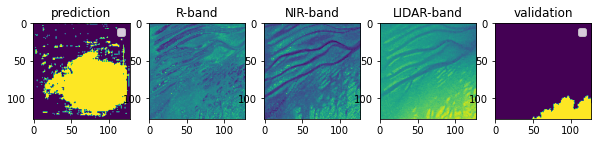

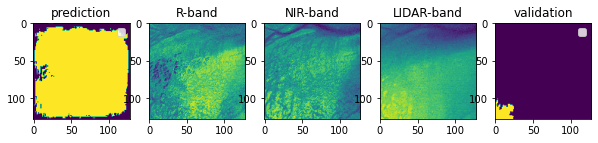

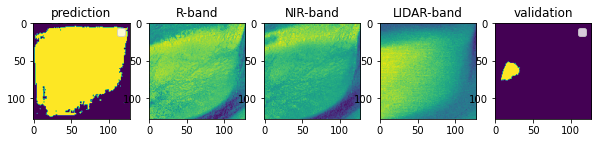

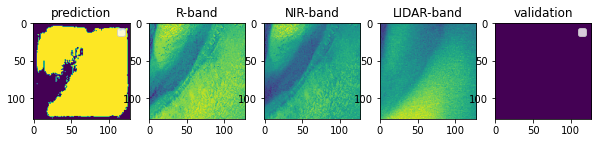

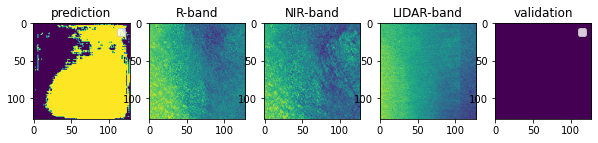

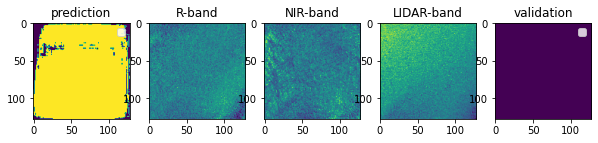

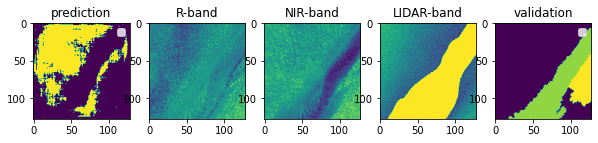

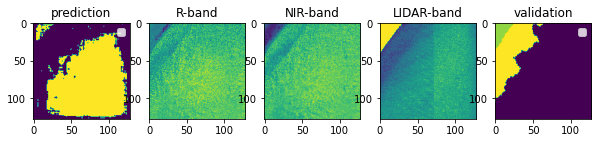

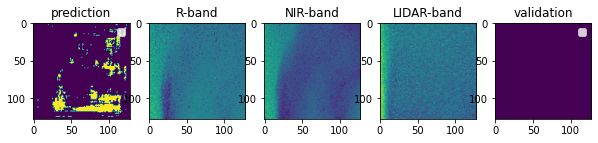

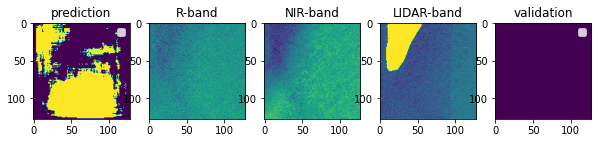

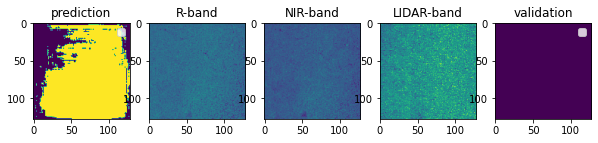

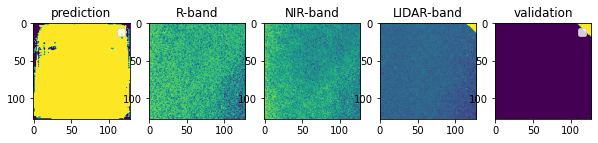

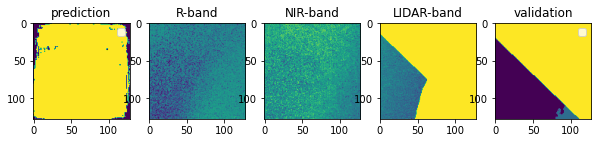

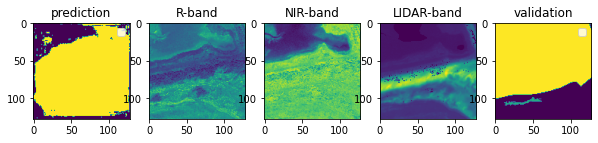

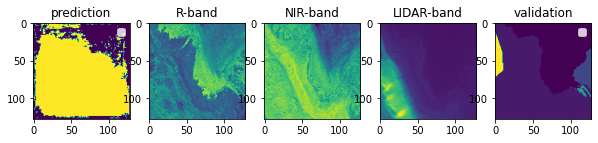

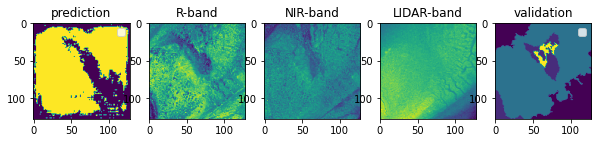

In [149]:

runner_out = runner.predict_loader(loader=loaders["valid"])

for i, output in enumerate (runner_out):   
    if i == 3: 
        
        output =  output["logits"].cpu() 
        output = (output > .8).detach().numpy().astype(int)
        for j in range (bs):
            #print(f"{i} th batch {j} th image")
            
            plt.figure(figsize=(10,10))
            
            output2 = np.sum(output[j,], axis = 0).astype(bool).astype(int)
       
            plt.subplot(1 ,5, 1 )
            
            plt.imshow(output2)
            plt.title('prediction')
            plt.legend(f"{j}")
            plt.subplot(1 ,5, 2 )
            plt.imshow(validation[i*16+j,2,])
            plt.title('R-band') 
            plt.subplot(1 ,5, 3 )
            plt.imshow(validation[i*16+j,1,])
            plt.title('NIR-band') 
            plt.subplot(1 ,5, 4)
            plt.imshow(validation[i*16+j,0,])
            plt.title('LIDAR-band') 
            plt.subplot(1 ,5, 5)
            plt.imshow(y_val[i*16+j,]) 
            plt.title('validation')
            plt.legend()

            plt.show()

In [131]:
''' # probabilistic
runner_out = runner.predict_loader(loader=loaders["valid"])
wh = 2
plt.figure(figsize=(18,18))
for i, output in enumerate (runner_out):   
    if i == 0: 
        print(i)
        for j in range(1,10): 
            
            plt.subplot(10,3, 1+3*(j-1))
            plt.imshow(output['logits'].cpu()[wh,j,])
            plt.subplot(10,3, 2+3*(j-1))
            plt.imshow(validation[wh,2,])
            plt.subplot(10, 3, 3+3*(j-1))
            plt.imshow(new_mas_val[wh,j,]) 
'''            

' # probabilistic\nrunner_out = runner.predict_loader(loader=loaders["valid"])\nwh = 2\nplt.figure(figsize=(18,18))\nfor i, output in enumerate (runner_out):   \n    if i == 0: \n        print(i)\n        for j in range(1,10): \n            \n            plt.subplot(10,3, 1+3*(j-1))\n            plt.imshow(output[\'logits\'].cpu()[wh,j,])\n            plt.subplot(10,3, 2+3*(j-1))\n            plt.imshow(validation[wh,2,])\n            plt.subplot(10, 3, 3+3*(j-1))\n            plt.imshow(new_mas_val[wh,j,]) \n'

In [132]:

''' plot
#plt.style.use("ggplot")
#%matplotlib inline

sigmoid = lambda x: 1/(1 + np.exp(-x))

for i, (input, output) in enumerate(zip(validation, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output =  output["logits"].copy()
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, "gray")
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, "gray")
    
    plt.show()
'''

' plot\n#plt.style.use("ggplot")\n#%matplotlib inline\n\nsigmoid = lambda x: 1/(1 + np.exp(-x))\n\nfor i, (input, output) in enumerate(zip(validation, runner_out)):\n    image, mask = input\n    \n    threshold = 0.5\n    \n    plt.figure(figsize=(10,8))\n    \n    \n    plt.imshow(image, \'gray\')\n    \n    plt.subplot(1, 3, 2)\n    output =  output["logits"].copy()\n    output = (output > threshold).astype(np.uint8)\n    plt.imshow(output, "gray")\n    \n    plt.subplot(1, 3, 3)\n    plt.imshow(mask, "gray")\n    \n    plt.show()\n'

How to update a model
https://heartbeat.fritz.ai/image-segmentation-with-transfer-learning-pytorch-5ada7121c6ab

In [133]:
'''#for loop way of class2dimm
def class2dim2 (mask, num_class):
    
    new_mask = np.reshape(np.tile(mask, num_class), ( mask.shape[0], mask.shape[1],mask.shape[2], num_class))
 
    for j in range(mask.shape[0]):
         aslice = new_mask[j,]
         amask = mask[j,]
         for i in range(num_class):
             aslice[:,:,i] = np.multiply(amask == i+1,1)        
         new_mask[j,]=aslice
    return new_mask
    
a = class2dim2(y_train, num_class)
a.shape
comparison = a == new_mask
equal_arrays = comparison.all()
print(equal_arrays)
'''




'#for loop way of class2dimm\ndef class2dim2 (mask, num_class):\n    \n    new_mask = np.reshape(np.tile(mask, num_class), ( mask.shape[0], mask.shape[1],mask.shape[2], num_class))\n \n    for j in range(mask.shape[0]):\n         aslice = new_mask[j,]\n         amask = mask[j,]\n         for i in range(num_class):\n             aslice[:,:,i] = np.multiply(amask == i+1,1)        \n         new_mask[j,]=aslice\n    return new_mask\n    \na = class2dim2(y_train, num_class)\na.shape\ncomparison = a == new_mask\nequal_arrays = comparison.all()\nprint(equal_arrays)\n'

In [134]:
''' # Not using catalyst, the lost is a different format 

from torch.utils.data import DataLoader, TensorDataset 
def myloader(trainX, trainY, valX,valY):
    train = TensorDataset(torch.Tensor(trainX[:,0:3,:,:]), torch.Tensor(trainY )) # create your datset
    train  = DataLoader(train, batch_size=bs) # create your dataloader
    
    vali= TensorDataset(torch.Tensor(valX[:,0:3,:,:]),torch.Tensor(valY  )) # create your datset
    vali = DataLoader(vali, batch_size=bs) # create your dataloader
    return train , vali 

train_loader, valid_loader = myloader(training, new_mask, validation, new_mas_val)
 # torch.LongTensor() for some losses
CLASSES = [format(x, '2d') for x in  classes]
 
model = smp.Unet(classes=len(CLASSES), in_channels=3,activation="sigmoid")
#newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
#print(model)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

print(len(CLASSES))
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
#model = smp.FPN(
#    encoder_name=ENCODER, 
#    encoder_weights=ENCODER_WEIGHTS, 
#    classes=len(CLASSES), 
#    activation=ACTIVATION,
#)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

loss = smp.utils.losses.DiceLoss()
#loss=nn.BCELoss(reduction = 'sum')
#WithLogits
#loss = nn.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
max_score = 0

for i in range(0, EPOCH):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5

        print('Decrease decoder learning rate to 1e-5!')

best_model = torch.load('./best_model.pth')
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
for i in range(10):
    x_tensor = torch.from_numpy(validation[:,0:3,:,:]).to(DEVICE)     
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
        
    visualize( 
        predicted_mask=pr_mask[2,i,:,:]
    )
plt.imshow(validation[2,1,:,:])
plt.show()
plt.imshow(y_val[2,:,:])
''' 

' # Not using catalyst, the lost is a different format \n\nfrom torch.utils.data import DataLoader, TensorDataset \ndef myloader(trainX, trainY, valX,valY):\n    train = TensorDataset(torch.Tensor(trainX[:,0:3,:,:]), torch.Tensor(trainY )) # create your datset\n    train  = DataLoader(train, batch_size=bs) # create your dataloader\n    \n    vali= TensorDataset(torch.Tensor(valX[:,0:3,:,:]),torch.Tensor(valY  )) # create your datset\n    vali = DataLoader(vali, batch_size=bs) # create your dataloader\n    return train , vali \n\ntrain_loader, valid_loader = myloader(training, new_mask, validation, new_mas_val)\n # torch.LongTensor() for some losses\nCLASSES = [format(x, \'2d\') for x in  classes]\n \nmodel = smp.Unet(classes=len(CLASSES), in_channels=3,activation="sigmoid")\n#newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))\n#print(model)\n\nENCODER = \'se_resnext50_32x4d\'\nENCODER_WEIGHTS = \'imagenet\'\n\nprint(len(CLASSES))\nACTIVATION = \'sigmoid\' # could be None fo